# Test Reconstruction

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import h5py

import torch.utils.data.dataloader

import src.models.predict_model as predict
import src.data.load_dataset
from src.config.load_config import load_config
from src.visualization.visualize import visualize_signal_pairs, visualize_latent_space
from src.common import merge_into_flat_one


project_dir = Path(predict.__file__).resolve().parents[2]
os.chdir(project_dir)


## Create Data Loaders

In [2]:
data_path = Path('data/processed')
experiment_cfg_path = Path('config/experiment.yaml')

# config loader
cfg = load_config(experiment_cfg_path) 
N = cfg['prediction']['num_samples']
L = cfg['model']['architecture']['num_input']
t = np.arange(L)/16000

# data loader
dataset_name_prefix = cfg['dataset']['name']
test_dataset = src.data.load_dataset.Waveform_dataset(data_path, '{}_test.hdf5'.format(dataset_name_prefix))
test_loader = torch.utils.data.dataloader.DataLoader(dataset=test_dataset, **cfg['test_loader'])
# model
model_save_path = Path(cfg['model']['path']) / cfg['model']['name'] 
print(model_save_path)

# labels
with h5py.File(data_path / 'y_test.hdf5', 'r') as y_file:
    frequencies = y_file['frequencies'][:]
    phases = y_file['phases'][:]



models/VAE-4layer-silu-nodo-nobn-0.05.pt


## Run Inference

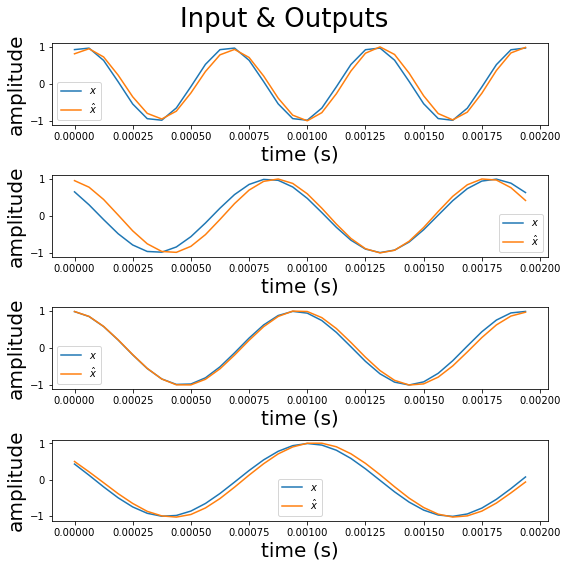

In [16]:
predictor = predict.Prediction(cfg['model'], model_save_path, **cfg['training'])
inputs = [x.numpy() for x in test_loader]
results = predictor.predict(test_loader)
results_latent = predictor.to_latent_space(test_loader)

latent = np.concatenate(results_latent, axis=0)
latent = merge_into_flat_one(latent).reshape((len(test_dataset),-1))


inputs, results = np.concatenate(inputs, axis=0), np.concatenate(results, axis=0)
inputs = np.reshape(inputs, (len(test_dataset), -1))
results = np.reshape(results, (len(test_dataset), -1))

visualize_signal_pairs(t, inputs, results, N=N)


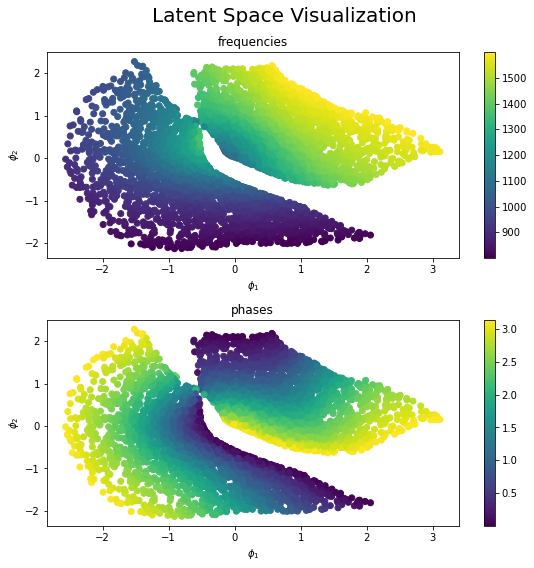

In [19]:
visualize_latent_space(latent, {'frequencies' : frequencies, 'phases' : phases})